# Rebirth the Remains
## An analysis using NLP tools across the lyrics of two greatest bands of Brazilian Heavy Metal: Angra and Sepultura


### Motivation
In most of my time, I used to experiment some NLP techniques and I noticed that even with the plethora of resources available, it's very hard to find some NLP tech stuff attached with Data Analysis, _i.e._ related to general knowledge over the data like Text Mining.  

It's very cool to have a lot of scripts, applied blog posts, repositories in Github with code, but at least for me the analysis it's where the technique shines most because anyone it's able to write a script but only a few ones can extract knowledge of the data. 

The idea here it's getting the lyrics of two bands that I like and check their literary characteristics and try to find some relation or distinction between them.  

For very deep and technical posts about NLP, LDA and so on, feel free to jump directly to the end of this post and choose a lot of very nice references about these topics.

And this is what this post what about and was deeply inspired for a great job of the [Machine Learning Plus](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/).  


### Why Angra and Sepultura?  
Heavy Metal it's one of the most borderless music styles in the world and I would like to show two of the most iconic bands of my country and their literary characteristics in a simple way using Python, LDA, NLP and some imagination (you will see during the "interpretation" of topics.  

### About the Bands

#### Sepultura
[Sepultura](https://en.wikipedia.org/wiki/Sepultura) is a Brazilian heavy metal band from Belo Horizonte. Formed in 1984 by brothers Max and Igor Cavalera, the band was a major force in the groove metal, thrash metal, and death metal genres during the late 1980s and early 1990s. Sepultura has also been credited as one of the second wave of thrash metal acts from the late 1980s and early-to-mid 1990s.  

[Sepultura Oficial Website](https://www.sepultura.com.br/) - [Sepultura in Spotify](https://open.spotify.com/artist/6JW8wliOEwaDZ231ZY7cf4)

#### Angra
[Angra](https://en.wikipedia.org/wiki/Angra_(band)) is a Brazilian heavy metal band formed in 1991 that has gone through some line-up changes since its foundation. Led by Rafael Bittencourt, the band has gained a degree of popularity in Japan and Europe.   

[Angra Oficial Website](http://www.angra.net/) - [Angra in Spotify](https://open.spotify.com/artist/7IAXZaLTb6nkJr8RmVPn5y)



### Questions
Some personal questions that I always had about these bands and I'll try to answer with this notebook is: 
- 1) What's the literary characteristics for Angra and Sepultura?
- 2) Which type of thematics they talk about?
- 3) Who has more diversity in their topics?

### Some limitations 

- NLP it's still an unsolved problem even with all [over promissing](https://openai.com/blog/better-language-models/) about it. This two anthologic pieces by [Yoav Goldberg](https://medium.com/@yoav.goldberg/an-adversarial-review-of-adversarial-generation-of-natural-language-409ac3378bd7) and [The Gradient](https://thegradient.pub/frontiers-of-generalization-in-natural-language-processing/) put that in perspective;
- The creative process even with some patterns it's a very complex that can envolves a lot of poetic license. [In this video](https://www.youtube.com/watch?v=G8eqnWVY_rU) Rafael Bittencourt explains the whole process to compose a single lyric for the new album, and in [this video](https://www.youtube.com/watch?v=kYf6GgkGfzA) Max Cavalera speaks about the creative process behind the classic album ["Roots"](https://www.youtube.com/watch?v=KuMlv7hmrFg&list=PLfUV806q_Ri4WN5omBcgzDxHcWMaHL_i1) from 1996.

### Applied techniques

#### Natual Language Processing
[Natural language processing (NLP)](https://en.wikipedia.org/wiki/Natural_language_processing) is a subfield of computer science, information engineering, and artificial intelligence concerned with the interactions between computers and human (natural) languages, in particular how to program computers to process and analyze large amounts of natural language data.

#### Topic Modeling
In machine learning and natural language processing, a [Topic Model](https://en.wikipedia.org/wiki/Topic_model) is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Topic models are also referred to as probabilistic topic models, which refers to statistical algorithms for discovering the latent semantic structures of an extensive text body. 

#### Latent Dirichlet Allocation
In natural language processing, [Latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model.  










### Data extraction and load
To extract the lyrics I used [`PyLyrics`](https://github.com/geekpradd/PyLyrics) library using [this script](https://github.com/fclesio/metalbr/blob/master/data-extraction.py). Important: This library doesn't have any update/bug fix since last year. 







In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os 
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import random
import re
import seaborn as sns
import spacy
import string
from collections import Counter
from PIL import Image
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en import English
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Generate graphs inline in Jupyter
%matplotlib inline
    
# Lock random seeds used by libraries
random.seed(42)
np.random.seed(42)

# Define default stopwords list
stoplist = ENGLISH_STOP_WORDS
    
# Define function to cleanup text by removing 
# personal pronouns, stopwords, and puncuation
nlp = spacy.load("en_core_web_sm")
punctuations = string.punctuation

# Datasets
filedir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(filedir, 'data/rebirth-remains.csv')

# Load file
df_raw_lyrics = pd.read_csv(filename, index_col=False)
df_raw_lyrics.columns = ['index','artist','album','lyric']

# One limitation of the wrapper that I used to get the data
# it's that contains a tons of bad records
df_raw_lyrics = df_raw_lyrics[pd.notnull(df_raw_lyrics['lyric'])]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("<span style=")]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("padding")]
df_raw_lyrics = df_raw_lyrics[~df_raw_lyrics["lyric"].str.contains("<img")]

# Basic counters
print(f'Qty rows: {df_raw_lyrics.shape[0]}, Qty columns: {df_raw_lyrics.shape[1]}')

# First look in the data
df_raw_lyrics.head(5)

Qty rows: 325, Qty columns: 4


,index,artist,album,lyric
0,0,sepultura,Bestial Devastation,"The curse is launched, beware\nThe Lord of Dea..."
1,1,sepultura,Bestial Devastation,A legion of demons\nBorn from boundaries of de...
2,2,sepultura,Bestial Devastation,Born from Hell\nThe supreme force of evil\nTo ...
3,3,sepultura,Bestial Devastation,The misfits high in this night\nCan feel the p...
4,4,sepultura,Bestial Devastation,Marching over the mist\nLeaving behind the wea...


The wrapper fetched 325 songs bringing the artist, lyric, and album.  

One of the main challenges it's that these band usually write songs in multi-language (EN and PT-BR). For a matter of simplicity, we'll concentrate only on the EN language.  

To filter the PT-BR songs I'll use `textblob` library that uses the Google API to check the language. The main caveat it's if you re-run a lot of times maybe you receive the code `HTTP Error 429: Too Many Requests`. 

In [2]:
def get_language(text):
    text = str(text)
    b = TextBlob(text)
    return b.detect_language()

# Include language in the DF
df_raw_lyrics['lang'] = df_raw_lyrics['lyric'].apply(get_language)

# Show stats about the language per artist
df_raw_lyrics.groupby(['artist', 'lang']).size().reset_index()

,artist,lang,0
0,angra,en,119
1,angra,pt,4
2,sepultura,en,194
3,sepultura,ja,1
4,sepultura,pt,7


Here we can see that from 325 lyrics **38% is from Angra** and **62% is from Sepultura**. Angra has **96% (119)** of all dataframe lyrics in EN and Sepultura have **96% (194)** of all lyrics in EN. 

The most remarkable song in PT-BR from Angra (IMHO) it's [Caça e Caçador](http://www.darklyrics.com/lyrics/angra/huntersandprey.html#8) what was a song from the album Hunters and Pray. In the Temple of Shadows album the song [Late Redemption](http://www.darklyrics.com/lyrics/angra/templeofshadows.html#12) it's a good piece in EN/PT-BR. 

Sepultura has some songs in PT-BR like [Filhos do Mundo](http://www.darklyrics.com/lyrics/sepultura/bestialdevastationsculoxx.html#7) from Bestial Devastation, [Prenuncio](http://www.darklyrics.com/lyrics/sepultura/against.html#17) from Against and [A Hora E A Vez Do Cabelo Nascer](https://www.letras.mus.br/sepultura/844256/) from the Beneath the Remains album that is a [cover song from Mutantes](https://www.youtube.com/watch?v=87vwhDPA8Z4). [The most remarkable](https://www.youtube.com/watch?v=4CWrVCAgcjg) one in PT-BR it's the [Policia](http://www.darklyrics.com/lyrics/sepultura/bloodrooted.html#3) song. 



In [3]:
# Filtering out non-EN songs
df_raw_lyrics = df_raw_lyrics[df_raw_lyrics['lang'] == 'en']

With all PT-BR lyrics removed let's perform a quick check in all albums of these bands.

In [4]:
# Lyrics per album
df_raw_lyrics.groupby(['artist', 'album']).size().reset_index()

,artist,album,0
0,angra,Angels Cry,9
1,angra,Aqua,10
2,angra,Aurora Consurgens,11
3,angra,Fireworks,11
4,angra,Freedom Call,8
5,angra,Holy Land,10
6,angra,Holy Live,4
7,angra,Hunters and Prey,7
8,angra,Omni,10
9,angra,Reaching Horizons,9


In a first look, considering our dataframe, we can see the first difference between these two bands that Sepultura has a larger discography and more songs per album.  

This can be explained with the fact that even both bands faced a hiatus in the time of that they changed their main singers ([Andre Matos](https://pt-br.facebook.com/AndreMatosOfficial/) and [Edu Falaschi](https://en.wikipedia.org/wiki/Eduardo_Falaschi) in Angra and [Max Cavalera](https://en.wikipedia.org/wiki/Max_Cavalera) by Sepultura) Sepultura released 8 albums after their break (all of them with [Derrick Green](https://en.wikipedia.org/wiki/Derrick_Green)) and in meanwhile Angra released 6; and Sepultura it's a more prolific band.  

Let's keep that information in mind because maybe it can be explained in the second moment in this analysis. 

Let's check the average songs per album.

In [5]:
# Average songs per album
df_albuns = df_raw_lyrics.groupby(['artist', 'album']).size().reset_index()
df_albuns.columns = ['artist', 'album', 'qty_tracks']
df_albuns.groupby(['artist']).agg({'qty_tracks': [np.size, np.mean]}).reset_index()

artist qty_tracks           
                   size       mean
0      angra         13   9.153846
1  sepultura         18  10.777778

As we visually inspected Sepultura not even have more albums, but have more songs per album. 

To start our analysis one important aspect of Text Analysis it's the **[data pre-processing](https://en.wikipedia.org/wiki/Data_pre-processing)**. Here we're literally can screw all analysis because the Pre-Processing it's responsible to remove all noise of the data and normalize all data to get meaningful results. [Kavita Ganesan](http://kavita-ganesan.com/text-preprocessing-tutorial/) made a great analysis of this topic and I strongly recommend the read.  


The first step will be to remove all English [stopwords](https://en.wikipedia.org/wiki/Stop_words) of all lyrics.  

PS: Personally I don't like to use off-the-shelf stopwords list because every domain demands specific words subsets to define if some word it's important or not. But let's keep that way for a matter of simplicity. This nice text of [Martina Pugliese](https://martinapugliese.github.io/english-stopwords/) explains it in detail. In terms of implementation [this article of ML Whiz](https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/) probably its the best resource available on the internet. 




In [6]:
# Convert the lyrics to string to not break the posterior converts
df_raw_lyrics['lyric'] = df_raw_lyrics['lyric'].astype(str)

# Remove all stopwords
df_raw_lyrics['lyric'] = df_raw_lyrics['lyric']\
    .apply(lambda x: ' '.join([item for item in x.lower()\
    .split() if item not in stoplist]))

# Quick check
df_raw_lyrics.head(5)

,index,artist,album,lyric,lang
0,0,sepultura,Bestial Devastation,"curse launched, beware lord death declared war...",en
1,1,sepultura,Bestial Devastation,legion demons born boundaries death like onsla...,en
2,2,sepultura,Bestial Devastation,born hell supreme force evil destroy altar sla...,en
3,3,sepultura,Bestial Devastation,misfits high night feel presence death way mor...,en
4,4,sepultura,Bestial Devastation,marching mist leaving weakest going endless wa...,en


After the stopwords removal, let's perform a quick visual check on the most frequent words used by these two bands. In other words: What's most used words in their compositions? 

In [7]:
# Data exploration in some specific class to see the most frequent words
def get_word_frequency(artist):

    # Word Frequency per Category
    def cleanup_text(docs, logging=False):
        texts = []
        counter = 1
        for doc in docs:
            if counter % 1000 == 0 and logging:
                print("Processed %d out of %d documents." % (counter, len(docs)))
            counter += 1
            doc = nlp(doc, disable=['parser', 'ner'])
            tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
            tokens = [tok for tok in tokens if tok not in stoplist and tok not in punctuations]
            tokens = ' '.join(tokens)
            texts.append(tokens)
        return pd.Series(texts)

    df_text = [text for text in df_raw_lyrics[df_raw_lyrics['artist'] == artist]['lyric']]
    df_text_clean = cleanup_text(df_text)
    df_text_clean = ' '.join(df_text_clean).split()
    df_text_clean_counts = Counter(df_text_clean)
    df_common_words = [word[0] for word in df_text_clean_counts.most_common(31)]
    df_common_counts = [word[1] for word in df_text_clean_counts.most_common(31)]
    df_common_words.pop(0)
    df_common_counts.pop(0)

    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=df_common_words, y=df_common_counts)
    plt.title(f'Most Common Words used by {artist}')
    plt.xticks(rotation=45)
    plt.show()
    
    fig.savefig(f'word_frequency_{artist}.png', format='png', dpi=500)

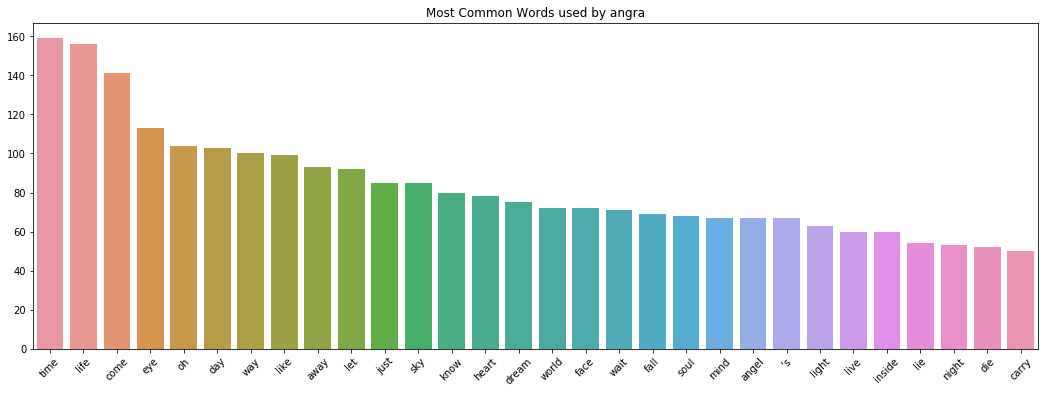

In [8]:
# Most Common words: Angra
get_word_frequency('angra')

If I could to perform some classification here to define Angra Lyrics based in their most common expressions would be like that: 

- Time relation: `Time`, `Day`, `Wait`, `Night`  


- Feelings: `Like`, `Heart`, `Soul`, `Lie`  

    
- Moviment and distance: `Come`, `Way`, `Away`, `Carry`  


- Living and mind: `Life`, `Let`, `Know`, `Dream`, `Mind`, `Live`, `inside`, `Leave`  

    
- Absolute state of the world: `Die`  

    
- Typical Heavy Metal cliché expression: `Oh`


Now, a quick verification in Sepultura lyrics:

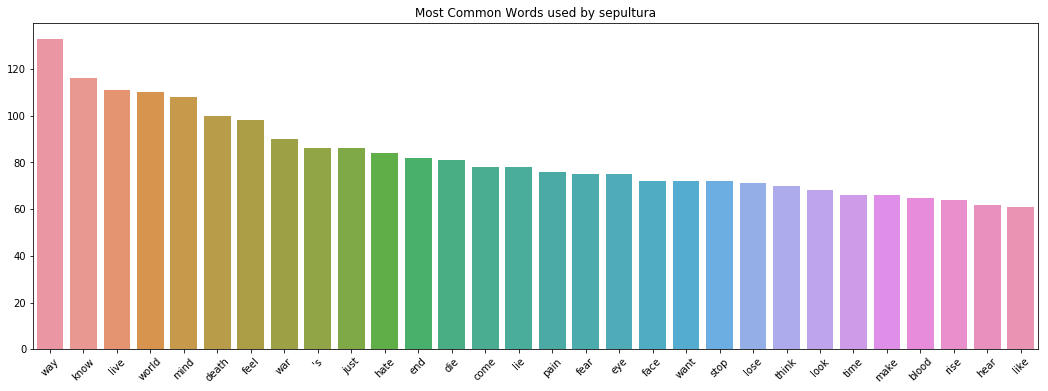

In [9]:
# Most Common words: Sepultura
get_word_frequency('sepultura')

State of the modern world: `Death`, `War`, `Hate`, `Die`, `Lie`, `Pain`, `Lose`, `Fear`, `Blood`, `World`

Action, distance and time: `Way`, `Come`, `Stop`, `Make`, `Rise`, `Time`, `Think`, `Hear`, `Know`

Mind issues: `Live`, `Mind`, `Feel`, `Want`, `Look`, `Inside`  




#### Latent Differences
Some latent differences about the themes discussed between Sepultura and Angra arise like:  

- The axis of compositional literature of **Sepultura converges on subjects related to the theme of things/feelings linked to death**, pain, war, hatred (if you already don't know, Sepultura means "Grave" in PT-BR) which are considered the most aggressive/heavy themes;  

- **Angra** has a lighter theme talking more about **existential issues that involve the passage of time,** as well as some songs that have feelings linked to dreams and feelings linked to **internal conflicts**.  



Let's see the word cloud relative to the most frequent words of the two bands, only for a small comparison according to all the vocabulary used by the bands.

In [10]:
# Word cloud with most common words
def show_wordcloud(text, artist):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=stoplist, background_color="white").generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(25,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {artist}', fontsize=20)
    plt.axis("off")
    plt.show()
    fig.savefig(f'word_cloud_{artist}.png', format='png', dpi=500)
    
def get_wordcloud(df, artist):
    dataframe = df[df['artist'] == artist]
    # Get all texts and generate a cloud
    text = " ".join(review for review in dataframe.lyric)
    show_wordcloud(text, artist) 

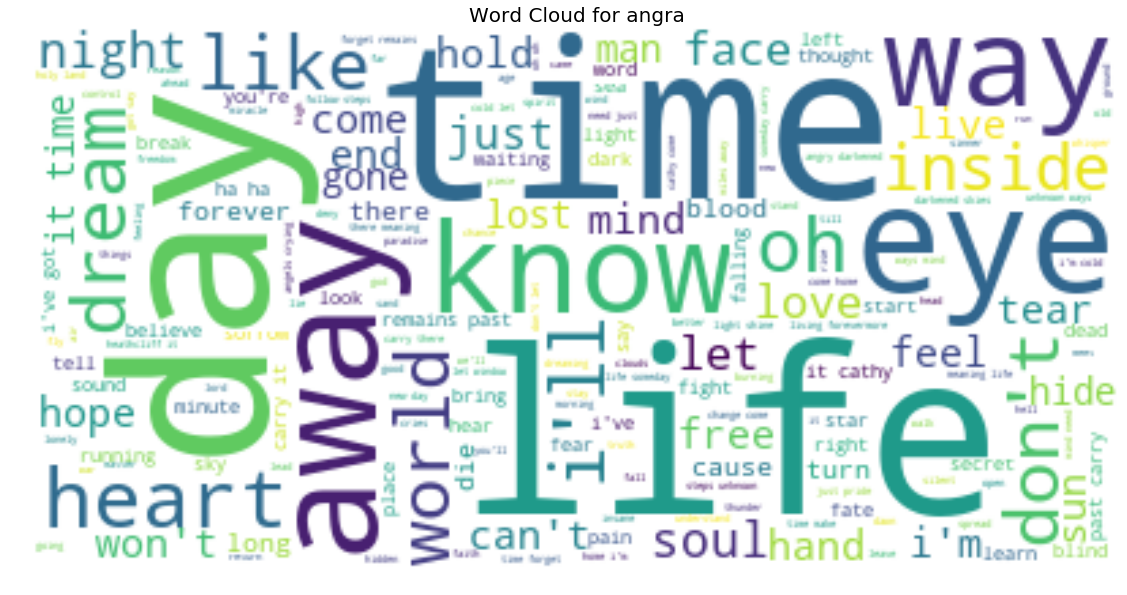

In [11]:
get_wordcloud(df_raw_lyrics, 'angra')

Main words Angra:
 - `life`, `time`, `know`, `heart`, `day`, `away`, `know`, `dream`

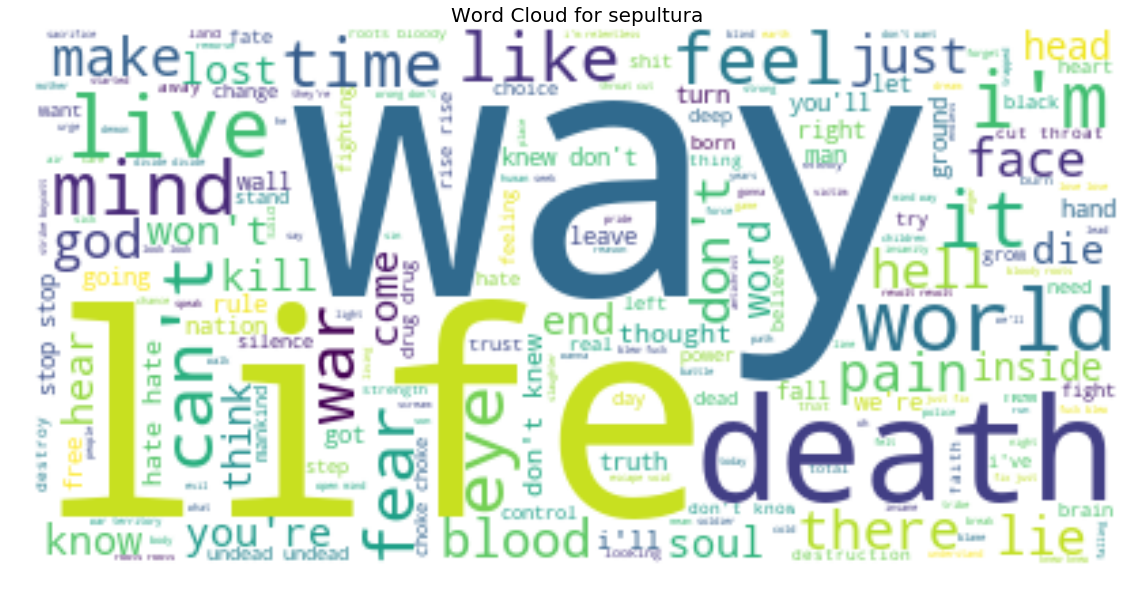

In [12]:
get_wordcloud(df_raw_lyrics, 'sepultura')

Main words Sepultura:
 - `way`, `life`, `death`, `world`, `mind`
 


### Lexical Diversity

According to [Johansson](https://journals.lub.lu.se/LWPL/article/view/2273) (2009) Lexical diversity is a measure of how *many different words that are used in a
text*. The practical use of the Lexical Diversity it's given by [McCarthy and Jarvis](https://link.springer.com/article/10.3758%2FBRM.42.2.381) (2010) they said that LD is *the range of different words used in a text, with a greater range indicating a higher diversity*.


A special consideration here it's that Heavy Metal songs it is not supposed to contain a lot of different words, *i.e.* a great lexical richness. It's because most of the cases each band can follow a single artistic concept and _shape their creative efforts_ to some themes and of course because most of the time this kind of song has a many chorus. 

For example (regarding of band concept) [Avatasia](https://en.wikipedia.org/wiki/Avantasia) it's a supergroup of Heavy Metal that talks about fiction, fantasy and religion; and in the other side [Dream Theater](https://en.wikipedia.org/wiki/Dream_Theater) talks about almost everything since [religion](https://genius.com/Dream-theater-in-the-name-of-god-lyrics) until [modern politics](https://www.azlyrics.com/lyrics/dreamtheater/thegreatdebate.html).


With this disclaimer let's check the Lexical Diversity of this bands.

In [13]:
def get_lexical_diversity(df, artist):
    dataframe = df[df['artist'] == artist]

    # Word stats
    full_text_count = pd.DataFrame(Counter(" ".join(dataframe["lyric"]).split()), index=[0])
    full_text_count = full_text_count.T
    full_text_count = full_text_count.reset_index()
    full_text_count.columns = ['word', 'qty']

    # Distinct words to include in numerator
    distinct_words = set()
    dataframe['lyric'].str.lower().str.split().apply(distinct_words.update)
    total_distinct_words = len(distinct_words)

    # All words to include in denominator
    total_words = full_text_count['qty'].sum()

    lexical_diversity = round((total_distinct_words / total_words),2)

    print(f'Lexical Diversity for {artist}: {lexical_diversity}')

In [14]:
get_lexical_diversity(df_raw_lyrics, 'angra')

Lexical Diversity for angra: 0.23


In [15]:
get_lexical_diversity(df_raw_lyrics, 'sepultura')

Lexical Diversity for sepultura: 0.24


There are almost no lexical diversity differences between these two bands, _i.e._ even using different words to shape their themes, there are no substantial lexical differences between them in terms of frequency in their themes.


### Word N-Grams

According to Wikipedia, [n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application](https://en.wikipedia.org/wiki/N-gram). 

In other others, n-grams it's sequences that contain _n_ words that can be used to model the probability of some sequence appears in a corpus, in our case, the n-gram(s) we can examine the most frequent combination of _n_ words in their literary dictionary.

For a matter of simplicity will focus on combinations of Bigrams `n=2` e Trigrams `n=3`.

In [16]:
def get_word_ngrams_list(df, artist, word_ngram):

    def get_top_word_n_bigram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(word_ngram, word_ngram)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]


    common_words = get_top_word_n_bigram(df[df['artist'] == artist]['lyric'], 20)
    df3 = pd.DataFrame(common_words, columns = ['ngram' , 'qty'])

    return df3

In [17]:
get_word_ngrams_list(df_raw_lyrics, 'angra', 2)

,ngram,qty
0,you re,53
1,carry on,29
2,it time,27
3,ve got,25
4,remains past,24
5,we re,24
6,you ve,24
7,ha ha,19
8,it me,18
9,me cathy,18


Here we can see some things:

- The "*You're*" it's the top combination in `n=2`. This indicates that along with the whole corpus of Angra's songs, there are lyrics that contain some kind of message being given to another person.

- One of the most frequent bigrams is `carry on` but this has a reason for the data: In this data set we have the `Angels Cry` and `Holy Live` disks that contain the song [Carry On](https://www.azlyrics.com/lyrics/angra/carryon.html) and this causes a _double counting_;  

- The reason behind of the `me cathy` and `cathy come` bigrams appears it's because of a cover song called [_Wuthering Heights_](https://www.azlyrics.com/lyrics/angra/wutheringheights.html) from [Kate Bush](https://en.wikipedia.org/wiki/Kate_Bush) that repeats this chorus a lot;  

- We have the traditional heavy metal song chorus filler cliché `oh oh` appearing
    


In [18]:
get_word_ngrams_list(df_raw_lyrics, 'angra', 3)

,ngram,qty
0,it me cathy,18
1,carry on it,16
2,on it time,16
3,it time forget,16
4,time forget remains,16
5,forget remains past,16
6,remains past carry,16
7,angry darkened skies,16
8,heathcliff it me,16
9,me cathy come,16


- Again appears in carry on in `carry on time`, `on time forget`, `remains past carry`, 
- `Cathy` Trigrams appears in: `heathcliff me cathy`, `me cathy come`,  `cathy come home`
- Some bizarre pattern like `ha ha ha`, probably because of the data cleansing


### Sepultura

In [19]:
get_word_ngrams_list(df_raw_lyrics, 'sepultura', 2)

,ngram,qty
0,we re,48
1,you re,41
2,no no,39
3,knew don,30
4,you ll,29
5,stop me,27
6,undead undead,24
7,me stop,21
8,choke choke,21
9,hate you,20


In these bi-grams we can already see a little more of Sepultura's theme linked to themes related to brutality as I had put it before. Some mentions:
- The song "[Choke](https://www.youtube.com/watch?v=MJI96zJm9G0)" has a very repetitive chorus, and that contributes to this composition of bi-grams.
- The same thing with the classic "[Roots](https://www.youtube.com/watch?v=nujq1JojZVE)" that has a very striking chorus

Let's go to the tri-grams:

In [20]:
get_word_ngrams_list(df_raw_lyrics, 'sepultura', 3)

,ngram,qty
0,no no no,26
1,undead undead undead,22
2,stop me stop,21
3,hate you hate,20
4,roots bloody roots,16
5,knew it knew,16
6,don that knew,16
7,cut throat cut,15
8,throat cut throat,15
9,me stop me,14


Here we see basically the same pattern with part of the tri-grams facing some very striking choruses.

Now we know a little about the theme of the two bands, however, a question that follows is: *Within this theme what are the latent topics behind each composition?*, i.e., there is a diversity within the themes inside the band's concept?, what if we could group these songs according to their literary composition?

And here's where we're going to use LDA. 


### LDA

First, we will filter each of the artists within their respective dataframe:

In [21]:
# LDA Analysis dataframes
df_raw_lyrics_angra = df_raw_lyrics[df_raw_lyrics['artist'] == 'angra']
df_raw_lyrics_sepultura = df_raw_lyrics[df_raw_lyrics['artist'] == 'sepultura']

To do topic distinction I'll arbitrarily chosen 7 topics for each artist (it can be more or less) only for didactic purposes and maintenance of simplicity.  

In other words: **Given all Angra and Sepultura lyrics, what are the top 7 topics that they usually write more?**

In [22]:
def get_topics(df, n_components, number_words):
    
    # Convert to list
    data = df.lyric.values.tolist()

    # Remove special characters
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    vectorizer = CountVectorizer(analyzer='word',       
                                 min_df=10,
                                 stop_words='english',
                                 lowercase=True,
                                 token_pattern='[a-zA-Z0-9]{3,}',
                                )

    data_vectorized = vectorizer.fit_transform(data)

    # Materialize the sparse data
    data_dense = data_vectorized.todense()

    # Compute Sparsicity = Percentage of Non-Zero cells
    print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

    # Build LDA Model
    lda_model = LatentDirichletAllocation(n_components=n_components,
                                          max_iter=10,
                                          learning_method='online',
                                          random_state=42,
                                          batch_size=10,
                                          evaluate_every = -1,
                                          n_jobs = -1,
                                         )
    lda_output = lda_model.fit_transform(data_vectorized)

    # Helper function
    def print_topics(model, count_vectorizer, n_top_words):
        words = count_vectorizer.get_feature_names()
        for topic_idx, topic in enumerate(model.components_):
            print("\nTopic #%d:" % topic_idx)
            print(" ".join([words[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]]))

    # Print the topics found by the LDA model
    print("Topics found via LDA:")
    lda_model.fit(data_vectorized)

    print_topics(lda_model, vectorizer, number_words)
    
    return lda_model, data_vectorized, data, lda_output, vectorizer

<>:7: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \s
<>:7: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \s
<>:7: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \s
<ipython-input-22-a356fdcb4faf>:7: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-22-a356fdcb4faf>:10: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


#### Topics Angra

In [23]:
lda_model_angra, data_vectorized_angra, \
data_angra, lda_output_angra, vectorizer_angra = \
    get_topics(df_raw_lyrics_angra, n_components=7, number_words=10)

Sparsicity:  15.461086395342448 %
Topics found via LDA:

Topic #0:
time dont day away way youre face pain just cause

Topic #1:
past remains theres life time forget need someday mind just

Topic #2:
let come like away day life wont wonder cold dreams

Topic #3:
thunder past remains forget someday night pray life pride know

Topic #4:
eyes time life ive world love say inside know got

Topic #5:
soul like just heart dreams learn ill sea sand free

Topic #6:
angels skies light life hide fly try free fall youre


#### Topics Sepultura

In [24]:
lda_model_sepultura, data_vectorized_sepultura, \
data_sepultura, lda_output_sepultura, vectorizer_sepultura = \
    get_topics(df_raw_lyrics_sepultura, n_components=7,number_words=10)

Sparsicity:  9.963501312672088 %
Topics found via LDA:

Topic #0:
war live world hear trust feel walk believe blood kill

Topic #1:
like hate love try born going pain earth theyre whats

Topic #2:
hell life death false bloody deep mind open born insane

Topic #3:
dont just away time fear youre know life right look

Topic #4:
wont way lies mind fall control truth man think free

Topic #5:
end theres dead world death feel eyes pain left alive

Topic #6:
way lost want stop cause die face dont need day


# Topic Per Document  

One important thing that we can do it's to generate a topic score for each document and based on that see which topic it's more dominant in a certain document. This is important because language can have several overlaps and combinations in words and ambiguity.  

One thing that can be made it's to define some score to assess the "purity" of some document inside a particular topic.  

Anyways this is a list of the 15 first tracks and their topics. 

In [25]:
def get_topic_per_document(lda_model, data_vectorized, data, lda_output):
    # Create Document - Topic Matrix
    lda_output = lda_model.transform(data_vectorized)

    # column names
    topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

    # index names
    docnames = ["Doc" + str(i) for i in range(len(data))]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic

    # Styling
    def color_green(val):
        color = 'green' if val > .1 else 'black'
        return 'color: {col}'.format(col=color)

    def make_bold(val):
        weight = 700 if val > .1 else 400
        return 'font-weight: {weight}'.format(weight=weight)

    # Apply Style
    df_document_topics_styled = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
    
    return df_document_topics_styled, df_document_topic

#### Topic per document Angra

In [26]:
df_topic_per_document_angra_styled, df_topic_per_document_angra = \
    get_topic_per_document(lda_model_angra,
                           data_vectorized_angra,
                           data_angra,
                           lda_output_angra)
df_topic_per_document_angra_styled

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,dominant_topic
Doc0,0,0.99,0,0,0,0,0,1
Doc1,0,0,0,0,0.99,0,0,4
Doc2,0,0,0,0,0,0,0.99,6
Doc3,0,0,0.98,0,0,0,0,2
Doc4,0,0,0.98,0,0,0,0,2
Doc5,0,0,0.98,0,0,0,0,2
Doc6,0.7,0.1,0,0,0.19,0,0,0
Doc7,0.99,0,0,0,0,0,0,0
Doc8,0.27,0.01,0.01,0.01,0.69,0.01,0.01,4
Doc9,0,0,0,0,0.98,0,0,4


And of course we can check the dominant topic along the time:

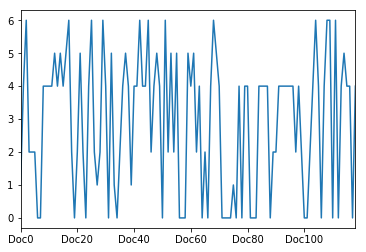

In [29]:
df_topic_per_document_angra['dominant_topic'].plot()

#### Topic per document Sepultura

In [30]:
df_topic_per_document_sepultura_styled, df_topic_per_document_sepultura = \
    get_topic_per_document(lda_model_sepultura,
                           data_vectorized_sepultura,
                           data_sepultura,
                           lda_output_sepultura)
df_topic_per_document_sepultura_styled

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,dominant_topic
Doc0,0.26,0.04,0.56,0.04,0.04,0.04,0.04,2
Doc1,0.01,0.63,0.33,0.01,0.01,0.01,0.01,1
Doc2,0.01,0.1,0.86,0.01,0.01,0.01,0.01,2
Doc3,0.01,0.01,0.44,0.01,0.01,0.01,0.52,6
Doc4,0.02,0.68,0.24,0.02,0.02,0.02,0.02,1
Doc5,0.01,0.01,0.16,0.01,0.16,0.65,0.01,5
Doc6,0.21,0,0.78,0,0,0,0,2
Doc7,0.01,0.01,0.01,0.01,0.01,0.96,0.01,5
Doc8,0.73,0,0.26,0,0,0,0,0
Doc9,0.01,0.01,0.32,0.01,0.01,0.65,0.01,5


Along the time this was the dominant topics for Sepultura:

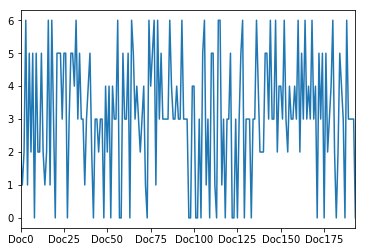

In [31]:
df_topic_per_document_sepultura['dominant_topic'].plot()

## Topic Distribution

In [32]:
def get_topic_distribution(df_document_topic):
    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    total_docs = df_topic_distribution['Num Documents'].sum()
    df_topic_distribution['perc_per_topic'] = np.round(((df_topic_distribution['Num Documents'] /total_docs) * 100), 2)

    return df_topic_distribution

In [33]:
get_topic_distribution(df_topic_per_document_angra)

,Topic Num,Num Documents,perc_per_topic
0,4,42,35.29
1,0,28,23.53
2,2,19,15.97
3,5,13,10.92
4,6,12,10.08
5,1,5,4.20


We can see here that much of Angra's thematics is focused on topics 4, 0, 2 which I call the topics *Look and know about the world along the time (#4)*, *Face the pain along the time (#0)*, and *In life dreams come and go away (#2)*

- `Topic #4: eyes time life ive world love say inside know got`

- `Topic #0: time dont day away way youre face pain just cause`

- `Topic #2: let come like away day life wont wonder cold dreams`

Right now let's check Sepultura:

In [34]:
get_topic_distribution(df_topic_per_document_sepultura)

,Topic Num,Num Documents,perc_per_topic
0,3,61,31.44
1,5,30,15.46
2,0,28,14.43
3,6,24,12.37
4,4,21,10.82
5,2,20,10.31
6,1,10,5.15


Sepultura focus on some topics such *life and fear time away(#3)*, *being alive in a world with pain and death(#5), and *Living in a world with war and blood spilling**


- `Topic #3: dont just away time fear youre know life right look`
- `Topic #5: end theres dead world death feel eyes pain left alive`
- `Topic #0: war live world hear trust feel walk believe blood kill`



## Word Topics
Here is only a table for us to check the order of the words in the topics that permeate the literary part of these two bands.

A special highlight here is that in this dataframe is also considered the frequency and ordinality of the word within the topic. 

In [35]:
def get_word_topics(vectorizer, lda_model):

    # Show top n keywords for each topic
    def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
        keywords = np.array(vectorizer.get_feature_names())
        topic_keywords = []
        for topic_weights in lda_model.components_:
            top_keyword_locs = (-topic_weights).argsort()[:n_words]
            topic_keywords.append(keywords.take(top_keyword_locs))
        return topic_keywords

    topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        

    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+ str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+ str(i) for i in range(df_topic_keywords.shape[0])]

    return df_topic_keywords

In [36]:
get_word_topics(vectorizer_angra, lda_model_angra)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,time,dont,day,away,way,youre,face,pain,just,cause
Topic 1,past,remains,theres,life,time,forget,need,someday,mind,just
Topic 2,let,come,like,away,day,life,wont,wonder,cold,dreams
Topic 3,thunder,past,remains,forget,someday,night,pray,life,pride,know
Topic 4,eyes,time,life,ive,world,love,say,inside,know,got
Topic 5,soul,like,just,heart,dreams,learn,ill,sea,sand,free
Topic 6,angels,skies,light,life,hide,fly,try,free,fall,youre


In [37]:
get_word_topics(vectorizer_sepultura, lda_model_sepultura)

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,war,live,world,hear,trust,feel,walk,believe,blood,kill
Topic 1,like,hate,love,try,born,going,pain,earth,theyre,whats
Topic 2,hell,life,death,false,bloody,deep,mind,open,born,insane
Topic 3,dont,just,away,time,fear,youre,know,life,right,look
Topic 4,wont,way,lies,mind,fall,control,truth,man,think,free
Topic 5,end,theres,dead,world,death,feel,eyes,pain,left,alive
Topic 6,way,lost,want,stop,cause,die,face,dont,need,day


## Topic Plotting with word distribution

Here with the `pyLDAvis` library, we can take a look in how the topics are distributed via visual inspection. The graph presented by `pyLDAvis` it's called Intertopic Distance Map that consists in a [two-dimensional plane whose centers are determined by computing the distance between topics, and then by using multidimensional scaling to project the intertopic distances onto two dimensions](http://www.kennyshirley.com/LDAvis/#topic=1&lambda=1&term=).

With that, we're able to interpret the composition of each topic and which individual terms are most useful inside of some topic. 

A most comprehensive introduction about the LDAVis can be found in [Sievert, C., & Shirley, K. (2014). LDAvis: A method for visualizing and interpreting topics. In Proceedings of the workshop on interactive language learning, visualization, and interfaces (pp. 63-70)](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf).

In [38]:
def get_lda_plot(lda_model, data_vectorized, vectorizer):
    pyLDAvis.enable_notebook()
    panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
    return panel

### LDA Plot for all Angra's Lyrics

In [39]:
get_lda_plot(lda_model_angra, data_vectorized_angra, vectorizer_angra)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4       19.631897  -89.571983       1        1  29.665389
0     -107.665268   36.818600       2        1  19.270076
2       65.441284   83.866554       3        1  17.412341
6      -26.175125 -263.009979       4        1  15.208356
5      146.931183 -215.962936       5        1  10.860251
1     -153.474792 -136.620255       6        1   7.245121
3      192.738098  -42.524849       7        1   0.338465, topic_info=    Category        Freq      Term       Total  loglift  logprob
97   Default   46.000000      past   46.000000  30.0000  30.0000
2    Default   58.000000    angels   58.000000  29.0000  29.0000
133  Default  146.000000      time  146.000000  28.0000  28.0000
72   Default   85.000000       let   85.000000  27.0000  27.0000
118  Default   60.000000      soul   60.000000  26.0000  26.0000
74   Default  138.000000      life  138.000000  25.0000  25.0000
32   Default  111.000000      eyes  111.000000  24.0000  24.0000
128  Default   51.000000    theres   51.000000  23.0000  23.0000
16   Default   78.000000      come   78.000000  22.0000  22.0000
76   Default   95.000000      like   95.000000  21.0000  21.0000
114  Default   41.000000     skies   41.000000  20.0000  20.0000
102  Default   33.000000   remains   33.000000  19.0000  19.0000
75   Default   63.000000     light   63.000000  18.0000  18.0000
89   Default   57.000000      mind   57.000000  17.0000  17.0000
66   Default   47.000000       ive   47.000000  16.0000  16.0000
4    Default   91.000000      away   91.000000  15.0000  15.0000
41   Default   34.000000       fly   34.000000  14.0000  14.0000
59   Default   37.000000      hide   37.000000  13.0000  13.0000
151  Default   54.000000     youre   54.000000  12.0000  12.0000
116  Default   35.000000   someday   35.000000  11.0000  11.0000
67   Default   82.000000      just   82.000000  10.0000  10.0000
108  Default   40.000000       say   40.000000   9.0000   9.0000
135  Default   30.000000       try   30.000000   8.0000   8.0000
44   Default   40.000000      free   40.000000   7.0000   7.0000
29   Default   42.000000    dreams   42.000000   6.0000   6.0000
43   Default   27.000000    forget   27.000000   5.0000   5.0000
63   Default   57.000000       ill   57.000000   4.0000   4.0000
21   Default   81.000000       day   81.000000   3.0000   3.0000
96   Default   28.000000      pain   28.000000   2.0000   2.0000
50   Default   32.000000       got   32.000000   1.0000   1.0000
..       ...         ...       ...         ...      ...      ...
130   Topic7    0.107876  thoughts   16.138297   0.6805  -5.0318
107   Topic7    0.107858      sand   16.931326   0.6324  -5.0320
13    Topic7    0.108058     close   17.055106   0.6270  -5.0301
131   Topic7    0.109514   thunder   17.309604   0.6255  -5.0167
138   Topic7    0.108401   unknown   17.741875   0.5907  -5.0269
127   Topic7    0.108461      tell   18.781421   0.5343  -5.0264
123   Topic7    0.108395      stay   19.097722   0.5170  -5.0270
124   Topic7    0.108433     steps   20.123844   0.4650  -5.0266
102   Topic7    0.109222   remains   33.273610  -0.0306  -5.0194
97    Topic7    0.109500      past   46.116582  -0.3545  -5.0168
43    Topic7    0.108671    forget   27.190131   0.1662  -5.0244
100   Topic7    0.108492     pride   26.325325   0.1969  -5.0261
116   Topic7    0.108628   someday   35.952196  -0.1135  -5.0248
94    Topic7    0.108595     night   44.580701  -0.3289  -5.0251
74    Topic7    0.108494      life  138.084475  -1.4604  -5.0261
68    Topic7    0.108492      know   67.680770  -0.7474  -5.0261
72    Topic7    0.108440       let   85.281911  -0.9790  -5.0266
133   Topic7    0.108438      time  146.775081  -1.5220  -5.0266
67    Topic7    0.108390      just   82.874271  -0.9508  -5.0270
31    Topic7    0.108365       end   34.477413  -0.0740  -5.0273
128   Topic7    0.108352    theres   51.695053  -0.4792

### LDA Plot for all Sepulturas's Lyrics

In [40]:
get_lda_plot(lda_model_sepultura, data_vectorized_sepultura, vectorizer_sepultura)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      -41.103737 -140.128784       1        1  26.314332
5       16.582518   -5.628982       2        1  14.761147
6     -128.740616  -22.921122       3        1  14.672357
0      -71.054016  111.578140       4        1  13.635737
2      161.906265   11.663836       5        1  11.837023
4      104.219444 -122.835327       6        1  11.715454
1       74.268784  128.870300       7        1   7.063951, topic_info=    Category        Freq     Term       Total  loglift  logprob
84   Default   63.000000     like   63.000000  30.0000  30.0000
59   Default   79.000000     hate   79.000000  29.0000  29.0000
152  Default  121.000000      way  121.000000  28.0000  28.0000
154  Default   69.000000     wont   69.000000  27.0000  27.0000
28   Default  169.000000     dont  169.000000  26.0000  26.0000
30   Default   73.000000      end   73.000000  25.0000  25.0000
150  Default   65.000000     want   65.000000  24.0000  24.0000
72   Default   92.000000     just   92.000000  23.0000  23.0000
90   Default   71.000000     lost   71.000000  22.0000  22.0000
130  Default   60.000000     stop   60.000000  21.0000  21.0000
91   Default   36.000000     love   36.000000  20.0000  20.0000
64   Default   51.000000     hell   51.000000  19.0000  19.0000
22   Default   82.000000    death   82.000000  18.0000  18.0000
21   Default   43.000000     dead   43.000000  17.0000  17.0000
134  Default   65.000000   theres   65.000000  16.0000  16.0000
12   Default   40.000000    cause   40.000000  15.0000  15.0000
85   Default   87.000000     live   87.000000  14.0000  14.0000
81   Default   48.000000     lies   48.000000  13.0000  13.0000
82   Default  120.000000     life  120.000000  12.0000  12.0000
8    Default   51.000000     born   51.000000  11.0000  11.0000
151  Default   76.000000      war   76.000000  10.0000  10.0000
38   Default   34.000000    false   34.000000   9.0000   9.0000
95   Default   79.000000     mind   79.000000   8.0000   8.0000
156  Default  104.000000    world  104.000000   7.0000   7.0000
143  Default   25.000000      try   25.000000   6.0000   6.0000
3    Default   53.000000     away   53.000000   5.0000   5.0000
27   Default   56.000000      die   56.000000   4.0000   4.0000
61   Default   45.000000     hear   45.000000   3.0000   3.0000
7    Default   28.000000   bloody   28.000000   2.0000   2.0000
103  Default   71.000000     pain   71.000000   1.0000   1.0000
..       ...         ...      ...         ...      ...      ...
143   Topic7   25.113465      try   25.993177   2.6157  -2.7088
135   Topic7   12.378415   theyre   13.218181   2.5845  -3.4163
59    Topic7   61.565667     hate   79.167640   2.3987  -1.8121
158   Topic7    8.163064    years   11.671481   2.2926  -3.8326
29    Topic7   12.422551    earth   18.336830   2.2608  -3.4127
53    Topic7   13.950550    going   26.403168   2.0122  -3.2967
153   Topic7   10.566382    whats   25.826291   1.7565  -3.5746
8     Topic7   19.071695     born   51.460592   1.6576  -2.9840
66    Topic7    7.039220    human   19.302113   1.6414  -3.9808
107   Topic7    4.025736   people   13.901090   1.4109  -4.5395
11    Topic7    3.399890  burning   13.046316   1.3054  -4.7085
31    Topic7    3.800578  endless   15.615960   1.2370  -4.5971
114   Topic7    4.793487    rules   20.301079   1.2067  -4.3650
87    Topic7    4.593269   living   24.342936   0.9825  -4.4077
103   Topic7   13.418893     pain   71.800140   0.9729  -3.3356
142   Topic7    4.904605    truth   30.216757   0.8319  -4.3421
109   Topic7    2.974981    power   20.025048   0.7434  -4.8420
16    Topic7    4.586858     come   35.790433   0.5957  -4.4091
34    Topic7    8.810274     eyes   69.757805   0.5811  -3.7563
104   Topic7    2.547064     past   21.535700   0.5154  -4.9973
96    Topic7    2.878967    minds   24.858249   0.4944  -4.8748
144   Topic7    1.944229     turn   21.3408

## Conclusion

Initially, I had 3 questions in mind and about the whole trip using NLP and LDA I personally think that I have some answers for them. 

**1) What are the literary characteristics for Angra and Sepultura?**  
**Answer**: **Angra** have as main literary characteristics themes related to the time and how the soul and life, mind and fate and waiting for something. 

**Sepultura** has a more aggressive literary composition where they speak about death, war and pain and they sing several times with some lyrics that face death. They protest against a lost or sick world most of the time.    

**2) Which type of thematics they talk about?**  
**Answer**: **Angra:** Time, soul and fate. Sepultura: Death, War, and World of Pain.

**3) Who has more diversity in their topics?**  
**Answer**: Using an arbitrary number 7 of topics we can see that Sepultura has more diversity in terms of the distribution of topics. 

## Further ideas and TODOs
- Include track names
- Compare Sepultura Eras (Max - Derrick)
- Compare Angra Eras (Mattos - Falaschi - Lioni)
- Similarity between tracks (Content-Based)
- Sepultura/Angra LSTM music lyric generator
- Topic evolution
- Dominant topic per album  
- Lyric Generation using LSTM







## References and useful links

- **Machine Learning Plus** - [LDA in Python – How to grid search best topic models?](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)  

- **Susan Li** - [Building a Content Based Recommender System for Hotels in Seattle](https://towardsdatascience.com/building-a-content-based-recommender-system-for-hotels-in-seattle-d724f0a32070)  

- **Susan Li** - [Automatically Generate Hotel Descriptions with LSTM](https://towardsdatascience.com/automatically-generate-hotel-descriptions-with-lstm-afa37002d4fc)  

- **Shashank Kapadia** - [End-To-End Topic Modeling in Python: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)  

- **Meghana Bhange** - [Arctic Monkeys Lyrics Generator with Data Augmentation](https://towardsdatascience.com/arctic-monkeys-lyrics-generator-with-data-augmentation-b9b1f7989db0)  

- **Greg Rafferty** - [LDA on the Texts of Harry Potter](https://towardsdatascience.com/basic-nlp-on-the-texts-of-harry-potter-topic-modeling-with-latent-dirichlet-allocation-f3c00f77b0f5)  

- **Code Academy** - [Using Machine Learning to Analyze Taylor Swift's Lyrics](https://news.codecademy.com/taylor-swift-lyrics-machine-learning/)

- **Alexander Bell** - [Music Lyrics Analysis: Using Natural Language Processing to create a Lyrics-Based Music Recommender](https://medium.com/@alexwbell/music-lyrics-analysis-using-natural-language-processing-to-create-a-lyrics-based-music-recommender-43e35896a4de)

- **Trucks and Beer** - [Amazing project with Lyrics scrapper](https://github.com/johnwmillr/trucks-and-beer)

- **Anders Olson-Swanson** - [Natural Language Processing and Rap Lyrics](https://towardsdatascience.com/natural-language-processing-and-rap-lyrics-c678e60073fb)

- **Brandon Punturo** - [Drake — Using Natural Language Processing to understand his lyrics](https://towardsdatascience.com/drake-using-natural-language-processing-to-understand-his-lyrics-49e54ace3662)

- **Degenerate State** - [Heavy Metal and Natural Language Processing - Part 1](http://www.degeneratestate.org/posts/2016/Apr/20/heavy-metal-and-natural-language-processing-part-1/)

- **Degenerate State** - [Heavy Metal and Natural Language Processing - Part 2](http://www.degeneratestate.org/posts/2016/Sep/12/heavy-metal-and-natural-language-processing-part-2/)

- **Degenerate State** - [Heavy Metal and Natural Language Processing - Part 3](http://www.degeneratestate.org/posts/2017/Jun/13/heavy-metal-and-natural-language-processing-part-3/)

- **Packt_Pub** - [Generating Lyrics Using Deep (Multi-Layer) LSTM](https://hackernoon.com/generating-lyrics-using-deep-multi-layer-lstm-b28ee8124936)  

- **Mohammed Ma'amari** - [AI Generates Taylor Swift’s Song Lyrics](https://towardsdatascience.com/ai-generates-taylor-swifts-song-lyrics-6fd92a03ef7e)  

- **Notebook Taylor Swift’s Song Lyrics** - [Link in Colab](https://colab.research.google.com/drive/1wlZXZBvOo93pAmTtEUeTlPsgAP4D1bLA)  

- **enrique a.** - [Word-level LSTM text generator. Creating automatic song lyrics with Neural Networks](https://medium.com/coinmonks/word-level-lstm-text-generator-creating-automatic-song-lyrics-with-neural-networks-b8a1617104fb)  

- **Ivan Liljeqvist** - [Using AI to generate lyrics](https://medium.com/@ivanliljeqvist/using-ai-to-generate-lyrics-5aba7950903)  

- **Sarthak Anand** - [Music Generator](https://github.com/isarth/generating_lyrics)  

- **Franklin Wang** - [song-lyrics-generation](https://github.com/frankxwang/song-lyrics-generation)  

- **Tony Beltramelli** - [Deep-Lyrics](https://github.com/tonybeltramelli/Deep-Lyrics) 